# DQN

Introduction.

In [1]:
import collections
import copy
import random

import gym
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True
np.random.seed(1234)
random.seed(1234)

## OpenAI Gym

Also, wrappers.

In [3]:
game = 'PongNoFrameskip-v4'

env = gym.make(game)

In [4]:
state = env.reset()

In [5]:
print(state.shape)

(210, 160, 3)


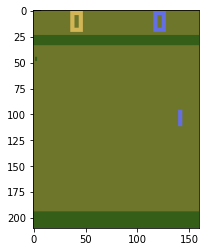

In [6]:
plt.imshow(state)

AtariPreprocessing does:
- no-op reset
- skip every four frames
- max the last two frames (cannot change)
- resize to 84x84
- convert to greyscale

In [7]:
env = gym.wrappers.AtariPreprocessing(env,
                                      noop_max=30,
                                      frame_skip=4,
                                      screen_size=84,
                                      terminal_on_life_loss=True,
                                      grayscale_obs=True)

In [8]:
state = env.reset()

In [9]:
print(state.shape)

(84, 84)


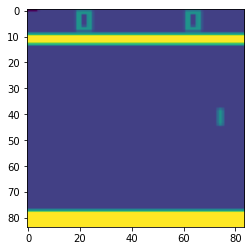

In [10]:
plt.imshow(state)

In [11]:
n_stack = 4

env = gym.wrappers.FrameStack(env,
                              num_stack=n_stack)

In [12]:
state = env.reset()

In [13]:
print(state.shape)

(4, 84, 84)


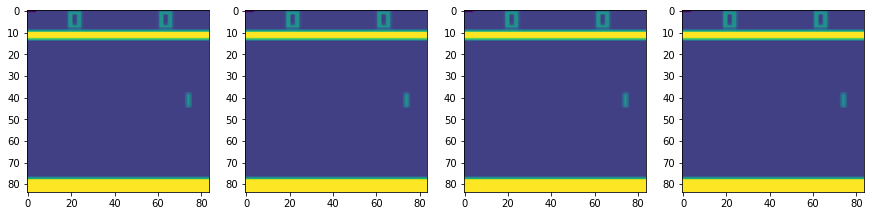

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(15,15))
for i, s in enumerate(state):
    ax[i].imshow(s)

In [15]:
env = gym.wrappers.TransformReward(env,
                                   lambda r: np.sign(r))

In [16]:
print(env.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [17]:
action = 0

for i in range(25):
    next_state, reward, done, info = env.step(action)

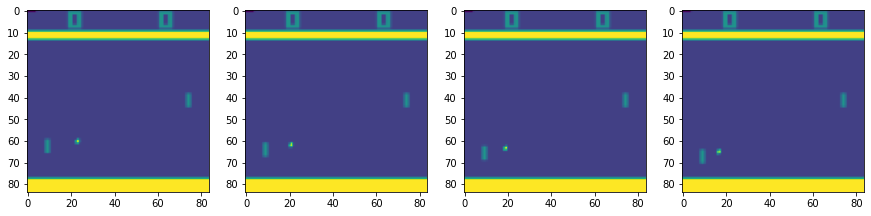

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(15,15))
for i, s in enumerate(next_state):
    ax[i].imshow(s)

In [19]:
env.seed(1234)

[1234, 142896654]

## Model

DQN model from DQN paper.

In [20]:
class DQN(nn.Module):
    def __init__(self, n_stack: int, n_actions: int):
        super().__init__()
        self.n_actions = n_actions
        self.conv1 = nn.Conv2d(n_stack, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, n_actions)
        
    def forward(self, x):
        batch_size, n_stack, height, width = x.shape
        assert (height, width) == (84, 84)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_action(self, state, epsilon, device):
        if random.random() < epsilon:
            action = random.randrange(self.n_actions)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(dim=0).to(device)
                q_value = self.forward(state)
                action = q_value.argmax(dim=-1).item()
        return action

## Replay Memory

Also called replay buffer, experience replay.

In [21]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state)
        action = torch.LongTensor([action])
        reward = torch.FloatTensor([reward])
        next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor([done])
        transition = (state, action, reward, next_state, done)
        self.memory.append(transition)
        
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.memory)

## Training

In [22]:
def train(env, model, replay_memory, optimizer, n_steps, update_freq,
          target_freq, print_freq, epsilons, batch_size, gamma, grad_clip,
          device):
    
    model = model.to(device)
    target_model = copy.deepcopy(model)
    model.train()
    model.eval()
    
    episode_steps = []
    episode_rewards = []
    episode_reward = 0

    state = env.reset()

    for step in tqdm.tqdm(range(n_steps)):

        epsilon = epsilons[step] if step < len(epsilons) else epsilons[-1]

        action = model.get_action(state, epsilon, device)

        next_state, reward, done, info = env.step(action)

        episode_reward += reward

        replay_memory.push(state, action, reward, next_state, done)

        state = next_state

        if step % update_freq == 0 and step > replay_memory.capacity:
            loss = optimize_model(model, target_model, replay_memory, optimizer,
                                  batch_size, gamma, grad_clip, device)

        if step % (update_freq * target_freq) == 0 and step > replay_memory.capacity:
            target_model.load_state_dict(model.state_dict())

        if done:
            episode_rewards.append(episode_reward)
            episode_steps.append(step+1)
            episode_reward = 0
            state = env.reset()
            
        if step % print_freq == 0 and step > replay_memory.capacity:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f'episodes: {len(episode_rewards)}, steps: {step}')
            print(f'epsilon: {epsilon}, reward: {avg_reward}')
            
    return episode_steps, episode_rewards

In [23]:
def optimize_model(model, target_model, replay_memory, optimizer, batch_size, gamma, grad_clip, device):
    
    states, actions, rewards, next_states, dones = replay_memory.sample(batch_size)
    
    states = torch.stack(states).to(device)
    actions = torch.stack(actions).to(device)
    rewards = torch.stack(rewards).to(device)
    next_states = torch.stack(next_states).to(device)
    dones = torch.stack(dones).to(device)
        
    q_preds = model(states)
    q_vals = q_preds.gather(dim=-1, index=actions)
    
    target_preds = target_model(next_states)
    target_vals = target_preds.max(dim=-1, keepdim=True).values
    
    expected_vals = rewards + (target_vals * gamma * (1 - dones))
    
    loss = F.smooth_l1_loss(q_vals, expected_vals.detach())
            
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    
    return loss.item()

In [24]:
capacity = 10_000

replay_memory = ReplayMemory(capacity)

In [25]:
start = 1.0
end = 0.01
decay = 30_000

epsilons = np.concatenate((np.ones(capacity), np.linspace(start, end, decay)), axis=0)

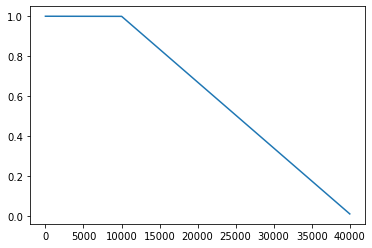

In [26]:
plt.plot(epsilons)

In [27]:
n_actions = env.action_space.n

model = DQN(n_stack, n_actions)

In [28]:
lr = 1e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
n_steps = 1_000_000
update_freq = 1
target_freq = 1_000
print_freq = 5_000
gamma = 0.99
batch_size = 32
grad_clip = 1.0

train(env, model, replay_memory, optimizer, n_steps, update_freq,
      target_freq, print_freq, epsilons, batch_size, gamma, grad_clip, device)

  2%|▏         | 15017/1000000 [01:34<2:53:08, 94.81it/s] 

episodes: 16, steps: 15000
epsilon: 0.8349944998166605, reward: -20.1


  2%|▏         | 20017/1000000 [02:25<2:54:11, 93.76it/s] 

episodes: 21, steps: 20000
epsilon: 0.669988999633321, reward: -20.0


  3%|▎         | 25017/1000000 [03:18<2:53:31, 93.65it/s]

episodes: 26, steps: 25000
epsilon: 0.5049834994499816, reward: -19.7


  3%|▎         | 30014/1000000 [04:13<3:01:51, 88.90it/s]

episodes: 31, steps: 30000
epsilon: 0.3399779992666422, reward: -19.6


  4%|▎         | 35014/1000000 [05:11<3:01:33, 88.59it/s]

episodes: 35, steps: 35000
epsilon: 0.1749724990833027, reward: -19.1


  4%|▍         | 40011/1000000 [06:07<3:03:56, 86.99it/s]

episodes: 38, steps: 40000
epsilon: 0.01, reward: -18.7


  5%|▍         | 45016/1000000 [07:06<3:12:57, 82.49it/s]

episodes: 41, steps: 45000
epsilon: 0.01, reward: -18.0


  5%|▌         | 50015/1000000 [08:06<3:10:17, 83.20it/s]

episodes: 44, steps: 50000
epsilon: 0.01, reward: -17.8


  6%|▌         | 55010/1000000 [09:06<3:08:41, 83.47it/s]

episodes: 46, steps: 55000
epsilon: 0.01, reward: -17.0


  6%|▌         | 60012/1000000 [10:06<3:05:38, 84.39it/s]

episodes: 49, steps: 60000
epsilon: 0.01, reward: -16.6


  7%|▋         | 65016/1000000 [11:05<3:06:08, 83.72it/s]

episodes: 52, steps: 65000
epsilon: 0.01, reward: -16.6


  7%|▋         | 70010/1000000 [12:05<3:04:10, 84.16it/s]

episodes: 54, steps: 70000
epsilon: 0.01, reward: -15.7


  8%|▊         | 75014/1000000 [13:05<3:04:22, 83.61it/s]

episodes: 57, steps: 75000
epsilon: 0.01, reward: -15.0


  8%|▊         | 80018/1000000 [14:04<3:01:24, 84.52it/s]

episodes: 59, steps: 80000
epsilon: 0.01, reward: -15.1


  9%|▊         | 85013/1000000 [15:03<3:14:48, 78.28it/s]

episodes: 62, steps: 85000
epsilon: 0.01, reward: -13.2


  9%|▉         | 90017/1000000 [16:01<2:57:13, 85.58it/s]

episodes: 63, steps: 90000
epsilon: 0.01, reward: -12.2


 10%|▉         | 95014/1000000 [16:59<2:54:09, 86.60it/s]

episodes: 66, steps: 95000
epsilon: 0.01, reward: -12.5


 10%|▉         | 96264/1000000 [17:14<3:01:11, 83.13it/s]